In [1]:
DATA_DIR = "./trash_dataset" 
MODEL_DIR = "./img_classification_models"

In [10]:
%pip install Pillow matplotlib torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 24.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 33.0 MB/s  0:00:20m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 36.8 MB/s  0:00:13m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 43.7 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 46.5 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 21.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 41.8 MB/s  0:00:14m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 46.6 MB/s  0:00:04m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 44.1 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 47.4 MB/s  0:00:05m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [3]:
# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(DATA_DIR)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(DATA_DIR, garbage_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")

        # Loop over each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))

# Determine if all images in the entore dataset have the same dimensions
if len(all_dimensions_set) == 1:
    width, height, channel = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")

paper folder contains 594 images.
plastic folder contains 482 images.
glass folder contains 501 images.
cardboard folder contains 403 images.
trash folder contains 137 images.
metal folder contains 410 images.

All images in the dataset have the same dimensions: 512x384 with 3 color channels.


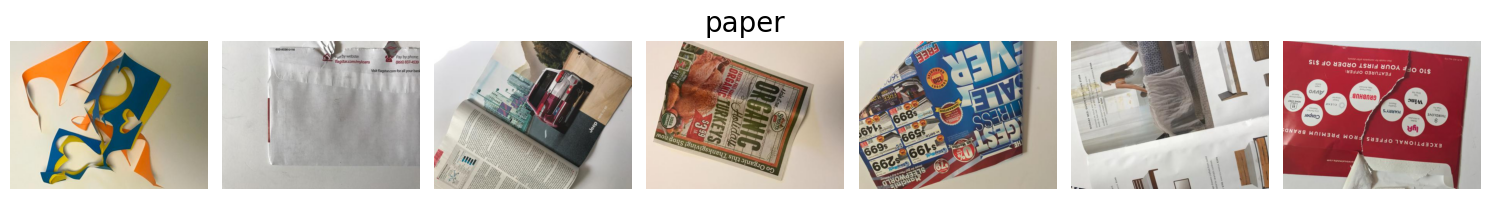

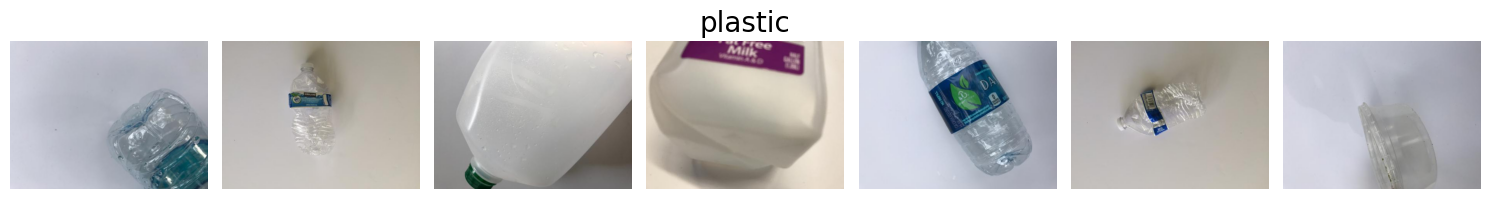

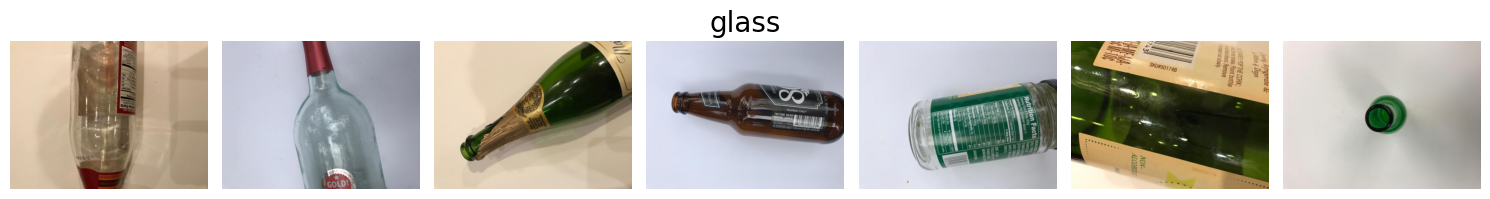

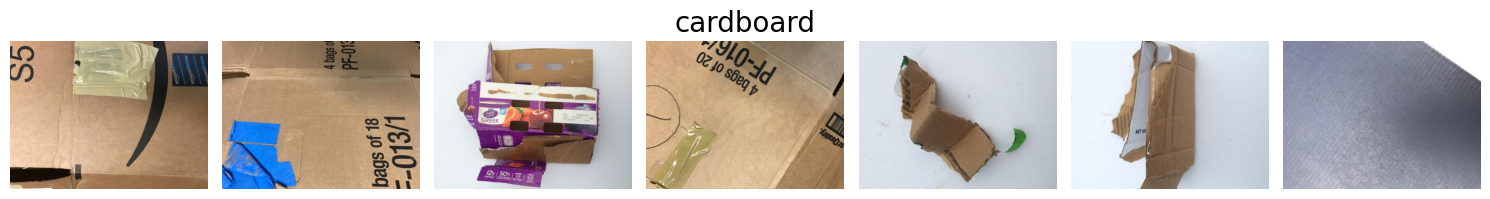

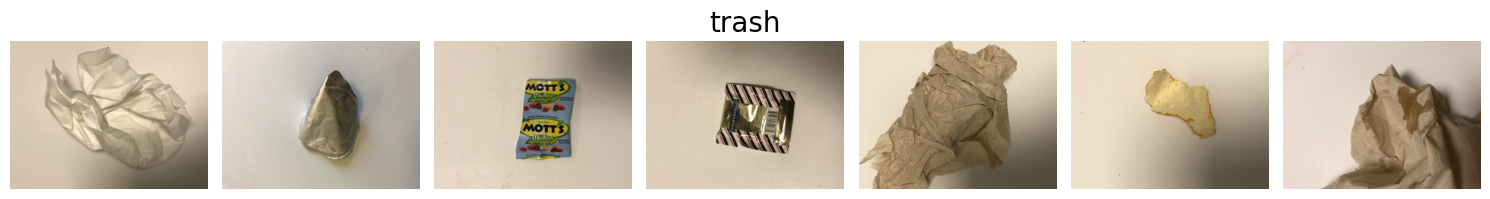

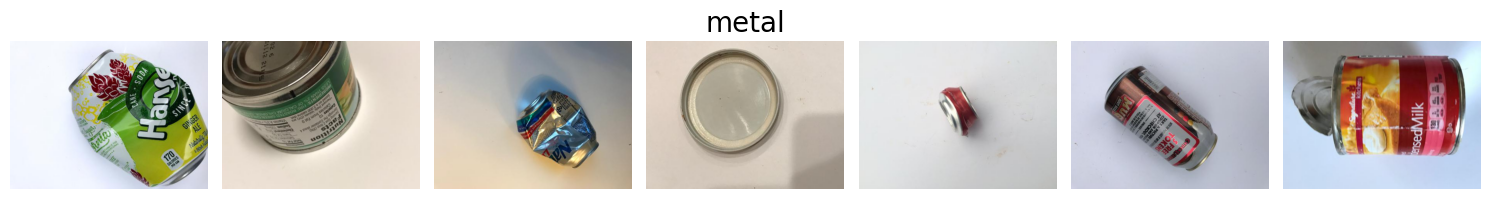

In [4]:
import matplotlib.pyplot as plt

# Iterate over each trash type (folder) to display images
for garbage_type in garbage_types:
    folder_path = os.path.join(DATA_DIR, garbage_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Select the first 10 images
        image_files = image_files[:7]

        # Set up subplots
        fig, axs = plt.subplots(1, 7, figsize=(15, 2))

        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')

        plt.tight_layout()
        fig.suptitle(garbage_type, fontsize=20, y=1.03)
        plt.show()

In [5]:
class GarbageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.classes = sorted(df['label'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'filepath']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label_idx = self.class_to_idx[label]
        return image, label_idx

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler

BATCH_SIZE=32
IMG_SIZE=224

def dataloader_process():
        # Initialize an empty list to store image file paths and their respective labels
    data = []

    # Loop through each garbage type and collect its images' file paths
    for garbage_type in garbage_types:
        for file in os.listdir(os.path.join(DATA_DIR, garbage_type)):
            # Append the image file path and its trash type (as a label) to the data list
            data.append((os.path.join(DATA_DIR, garbage_type, file), garbage_type))

    # Convert the collected data into a DataFrame
    df = pd.DataFrame(data, columns=['filepath', 'label'])

    # Display the first few entries of the DataFrame
    df.head()

    # Split with stratification
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

    # Print the number of images in each set
    print(f"Number of images in the training set: {len(train_df)}")
    print(f"Number of images in the validation set: {len(val_df)}")
    # Normalization values are standard for ImageNet-pretrained models
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    train_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    train_dataset = GarbageDataset(train_df, transform=train_transform)
    val_dataset = GarbageDataset(val_df, transform=val_transform)

    # === Class imbalance handling ===
    labels = [train_dataset.class_to_idx[lbl] for lbl in train_df['label']]
    class_sample_count = np.bincount(labels)
    class_weights = 1. / np.maximum(class_sample_count, 1)
    sample_weights = [class_weights[t] for t in labels]

    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, train_dataset, val_dataset, class_weights, labels

In [8]:
train_loader, val_loader, train_dataset, val_dataset, class_weights, labels = dataloader_process()
print(f"Labels: {list(train_dataset.class_to_idx.keys())}")

Number of images in the training set: 2021
Number of images in the validation set: 506
Labels: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
model = SimpleCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda
Number of classes: 6


In [10]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


num_classes = len(train_dataset.classes)
le = LabelEncoder()
le.fit(list(train_dataset.class_to_idx.keys()))
# ======================
# Training Function
# ======================
def train_cnn_model(
    train_loader,
    val_loader,
    class_weights,
    epochs=30,
    lr=1e-4,
    use_class_weights=True
):
    """
    Train a CNN classifier for garbage image classification.

    Args:
        train_loader: DataLoader with ['filepath', 'label']
        val_loader: DataLoader with ['filepath', 'label']
        epochs: int
        lr: float
        use_class_weights: whether to use class weights in loss (for imbalance)

    Returns:
        model, label_encoder, classification_report(str)
    """

    # === Model, Loss, Optimizer ===
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN(num_classes).to(device)

    if use_class_weights:
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # === Training Loop ===
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        # === Validation ===
        model.eval()
        val_correct, val_total = 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = outputs.max(1)
                val_correct += preds.eq(labels).sum().item()
                val_total += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = val_correct / val_total
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {total_loss/len(train_loader):.4f} - "
              f"Train Acc: {train_acc:.3f} - Val Acc: {val_acc:.3f}")

    # === Classification Report ===

    report = classification_report(
        le.inverse_transform(all_labels),
        le.inverse_transform(all_preds),
        digits=3
    )

    print("\nValidation Report:\n", report)
    return model, report

In [12]:
model, report = train_cnn_model(
    train_loader,
    val_loader,
    class_weights,
    epochs=20,
    lr=1e-4
)

Epoch 1/20 - Loss: 1.4525 - Train Acc: 0.323 - Val Acc: 0.393
Epoch 2/20 - Loss: 1.2305 - Train Acc: 0.435 - Val Acc: 0.466
Epoch 3/20 - Loss: 1.1141 - Train Acc: 0.484 - Val Acc: 0.433
Epoch 4/20 - Loss: 1.0416 - Train Acc: 0.509 - Val Acc: 0.514
Epoch 5/20 - Loss: 0.9196 - Train Acc: 0.554 - Val Acc: 0.496
Epoch 6/20 - Loss: 0.9286 - Train Acc: 0.559 - Val Acc: 0.551
Epoch 7/20 - Loss: 0.9007 - Train Acc: 0.591 - Val Acc: 0.579
Epoch 8/20 - Loss: 0.8650 - Train Acc: 0.588 - Val Acc: 0.611
Epoch 9/20 - Loss: 0.8908 - Train Acc: 0.592 - Val Acc: 0.571
Epoch 10/20 - Loss: 0.8486 - Train Acc: 0.596 - Val Acc: 0.585
Epoch 11/20 - Loss: 0.8090 - Train Acc: 0.635 - Val Acc: 0.593
Epoch 12/20 - Loss: 0.7903 - Train Acc: 0.642 - Val Acc: 0.603
Epoch 13/20 - Loss: 0.7524 - Train Acc: 0.656 - Val Acc: 0.632
Epoch 14/20 - Loss: 0.7411 - Train Acc: 0.667 - Val Acc: 0.579
Epoch 15/20 - Loss: 0.7864 - Train Acc: 0.655 - Val Acc: 0.634
Epoch 16/20 - Loss: 0.7374 - Train Acc: 0.664 - Val Acc: 0.684
E

In [17]:
import torch
import joblib
import os

os.makedirs(MODEL_DIR, exist_ok=True)

# Save model weights
torch.save(model.state_dict(), f"{MODEL_DIR}/cnn_model.pt")

# Save label encoder
joblib.dump(le, f"{MODEL_DIR}/label_encoder.pkl")

['./img_classification_models/label_encoder.pkl']

In [18]:
import joblib

# Recreate the same model architecture
model = SimpleCNN(num_classes=num_classes)
model.load_state_dict(torch.load(f"{MODEL_DIR}/cnn_model.pt", map_location="cpu"))
model.eval()

# Load label encoder
label_encoder = joblib.load(f"{MODEL_DIR}/label_encoder.pkl")

# Define transform (same as training)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [19]:
import pandas as pd
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import StringType
from pyspark.sql import SparkSession
import io

spark = SparkSession.builder \
.config("spark.driver.memory", "2g") \
.config("spark.executor.memory", "2g") \
.config("spark.executor.cores", 2) \
.getOrCreate()

@pandas_udf(StringType())
def predict_image_udf(path_series: pd.Series, image_series: pd.Series) -> pd.Series:
    preds = []
    for img_bytes in image_series: 
        # Convert bytes → PIL image 
        img = Image.open(io.BytesIO(img_bytes)).convert("RGB") 
        # Apply preprocessing 
        tensor = transform(img).unsqueeze(0) # Predict 
        with torch.no_grad(): 
            logits = model(tensor) 
            pred_idx = logits.argmax(dim=1).item() 
            pred_label = label_encoder.inverse_transform([pred_idx])[0] 
            preds.append(pred_label)
    return pd.Series(preds)


In [20]:
import random

def get_img_df(limit=20):
    """
    Randomly sample up to `limit` images (as bytes) from all garbage_type folders.
    Returns a Spark DataFrame with column: image_bytes
    """
    data = []

    for garbage_type in garbage_types:
        folder_path = os.path.join(DATA_DIR, garbage_type)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.lower().endswith(("jpg", "jpeg", "png")):
                    with open(os.path.join(folder_path, file), "rb") as f:
                        img_path = os.path.join(folder_path, file)
                        img_bytes = f.read()
                        data.append((img_path,img_bytes))

    # Randomly sample up to `limit` images
    if len(data) > limit:
        data = random.sample(data, limit)

    # Convert to pandas DataFrame
    df = pd.DataFrame(data, columns=["image_path", "image_bytes"])

    # Convert pandas → Spark DataFrame
    return spark.createDataFrame(df)

In [21]:
# 🔹 Create DataFrame of random 20 images
df_images = get_img_df(limit=20)

df_pred = df_images.withColumn("prediction", predict_image_udf(df_images["image_path"], df_images["image_bytes"]))

# ✅ Show results (paths and predictions)
df_pred.select("image_path", "prediction").show(truncate=False)

+-------------------------------------------+----------+
|image_path                                 |prediction|
+-------------------------------------------+----------+
|./trash_dataset/plastic/plastic_270.jpg    |glass     |
|./trash_dataset/cardboard/cardboard_107.jpg|trash     |
|./trash_dataset/cardboard/cardboard_361.jpg|glass     |
|./trash_dataset/glass/glass_009.jpg        |glass     |
|./trash_dataset/cardboard/cardboard_358.jpg|trash     |
|./trash_dataset/paper/paper_294.jpg        |trash     |
|./trash_dataset/metal/metal_028.jpg        |glass     |
|./trash_dataset/plastic/plastic_161.jpg    |glass     |
|./trash_dataset/metal/metal_056.jpg        |glass     |
|./trash_dataset/plastic/plastic_088.jpg    |glass     |
|./trash_dataset/metal/metal_364.jpg        |trash     |
|./trash_dataset/paper/paper_281.jpg        |trash     |
|./trash_dataset/paper/paper_002.jpg        |trash     |
|./trash_dataset/metal/metal_126.jpg        |trash     |
|./trash_dataset/cardboard/card